# Notebook 02 – Game Outcome Modelling

**Dependencies:** pandas, numpy, seaborn, matplotlib, scikit-learn.

## How to run this notebook
1. Install dependencies via `pip install -r requirements.txt`.
2. Start Jupyter from the project root for clean relative paths.
3. Execute cells in order; this will regenerate engineered team features, matchup datasets, models, and plots saved to `figures/` & `tables/`.
4. Use the outputs in the report’s Methods/Results sections.

## Setup

In [1]:
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

# Ensure src/ is importable whether notebook runs from root or notebooks/
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src import data_loading as dl
from src import feature_engineering as fe
from src import models_game_outcome as mgo
from src import evaluation as eval_utils

sns.set_theme(style="whitegrid")

FIG_DIR = PROJECT_ROOT / "figures"
TABLE_DIR = PROJECT_ROOT / "tables"
FIG_DIR.mkdir(exist_ok=True)
TABLE_DIR.mkdir(exist_ok=True)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Load and Engineer Team Features

In [2]:
team_season = dl.load_team_season()
teams = dl.load_teams()
team_features = fe.build_team_season_features(team_season, teams)
print(f"Team features: {team_features.shape}")
team_features.head()

Team features: (1319, 48)


,team,year,leag,o_fgm,o_fga,o_ftm,o_fta,o_oreb,o_dreb,o_reb,...,off_ppg,def_ppg,margin,off_rating,def_rating,turnover_rate,assist_rate,rebound_rate,opp_rebound_rate,team_name
0,BOS,1946,N,1397,5133,811,1375,0,0,0,...,60.083333,65.000000,-4.916667,0.0,0.0,0.0,7.833333,0.0,0.0,Boston Celtics
1,CH1,1946,N,1879,6309,939,1550,0,0,0,...,77.000000,73.295082,3.704918,0.0,0.0,0.0,7.147541,0.0,0.0,Chicago Stags
2,CL1,1946,N,1674,5699,903,1428,0,0,0,...,70.850000,71.800000,-0.950000,0.0,0.0,0.0,8.233333,0.0,0.0,Cleveland Rebels
3,DE1,1946,N,1437,5843,923,1494,0,0,0,...,63.283333,65.300000,-2.016667,0.0,0.0,0.0,8.033333,0.0,0.0,Detroit Falcons
4,NYK,1946,N,1465,5255,951,1438,0,0,0,...,64.683333,64.000000,0.683333,0.0,0.0,0.0,7.616667,0.0,0.0,New York Knicks


## Construct Pairwise Matchups

In [3]:
matchups = fe.build_pairwise_matchups(team_features)
print(f"Matchups dataset: {matchups.shape}")
matchups.head()

Matchups dataset: (33196, 15)


,year,team_a,team_name_a,team_b,team_name_b,label,diff_win_pct,diff_off_ppg,diff_def_ppg,diff_margin,diff_off_rating,diff_def_rating,diff_turnover_rate,diff_rebound_rate,diff_pace
0,1946,BOS,Boston Celtics,CH1,Chicago Stags,0,-0.272678,-16.916667,-8.295082,-8.621585,0.0,0.0,0.0,0.0,0.0
1,1946,BOS,Boston Celtics,CL1,Cleveland Rebels,0,-0.133333,-10.766667,-6.800000,-3.966667,0.0,0.0,0.0,0.0,0.0
2,1946,BOS,Boston Celtics,DE1,Detroit Falcons,1,0.033333,-3.200000,-0.300000,-2.900000,0.0,0.0,0.0,0.0,0.0
3,1946,BOS,Boston Celtics,NYK,New York Knicks,0,-0.183333,-4.600000,1.000000,-5.600000,0.0,0.0,0.0,0.0,0.0
4,1946,BOS,Boston Celtics,PH1,Philadelphia Warriors,0,-0.216667,-8.550000,-0.200000,-8.350000,0.0,0.0,0.0,0.0,0.0


## Train/Test Split (Season-Aware)

In [4]:
train_df, test_df = mgo.season_train_test_split(matchups, train_ratio=0.7)
train_seasons = sorted(train_df['year'].unique())
test_seasons = sorted(test_df['year'].unique())
print(f"Train seasons: {train_seasons[:3]} ... {train_seasons[-3:]}")
print(f"Test seasons: {test_seasons}")

X_train, y_train, feature_cols = mgo.prepare_features(train_df)
X_test = test_df[feature_cols]
y_test = test_df['label']

Train seasons: [np.int64(1946), np.int64(1947), np.int64(1948)] ... [np.int64(1984), np.int64(1985), np.int64(1986)]
Test seasons: [np.int64(1987), np.int64(1988), np.int64(1989), np.int64(1990), np.int64(1991), np.int64(1992), np.int64(1993), np.int64(1994), np.int64(1995), np.int64(1996), np.int64(1997), np.int64(1998), np.int64(1999), np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004)]


## Train Baseline and Advanced Models

In [5]:
models = mgo.train_models(train_df, feature_cols=feature_cols)
list(models.keys())

['logistic_regression', 'gradient_boosting', 'random_forest']

## Evaluate Models on Held-Out Seasons

In [6]:
evaluation_results = {}
for name, model in models.items():
    res = eval_utils.evaluate_classifier(model, X_test, y_test)
    evaluation_results[name] = res

metrics_df = eval_utils.metrics_to_dataframe(evaluation_results)
metrics_path = TABLE_DIR / "model_comparison.csv"
eval_utils.save_metrics_table(metrics_df, metrics_path)
print(f"Saved model metrics to {metrics_path}")
metrics_df

Saved model metrics to C:\Users\nkany\OneDrive\Desktop\Desktop\Machine Learning\Project\tables\model_comparison.csv


,accuracy,precision,recall,f1,roc_auc
model,,,,,
logistic_regression,0.999152,0.999152,0.999152,0.999152,0.999985
gradient_boosting,1.000000,1.000000,1.000000,1.000000,1.000000
random_forest,0.999879,0.999879,0.999879,0.999879,1.000000


## Confusion Matrices

In [7]:
for name in ["logistic_regression", "gradient_boosting"]:
    res = evaluation_results[name]
    cf_path = FIG_DIR / f"confusion_{name}.png"
    eval_utils.plot_confusion_matrix(y_test, res["y_pred"], title=f"{name.title()} Confusion Matrix", save_path=cf_path)
    plt.close()
    print(f"Saved confusion matrix for {name} to {cf_path}")

Saved confusion matrix for logistic_regression to C:\Users\nkany\OneDrive\Desktop\Desktop\Machine Learning\Project\figures\confusion_logistic_regression.png
Saved confusion matrix for gradient_boosting to C:\Users\nkany\OneDrive\Desktop\Desktop\Machine Learning\Project\figures\confusion_gradient_boosting.png


## ROC Curves

Saved ROC plot to C:\Users\nkany\OneDrive\Desktop\Desktop\Machine Learning\Project\figures\roc_models.png


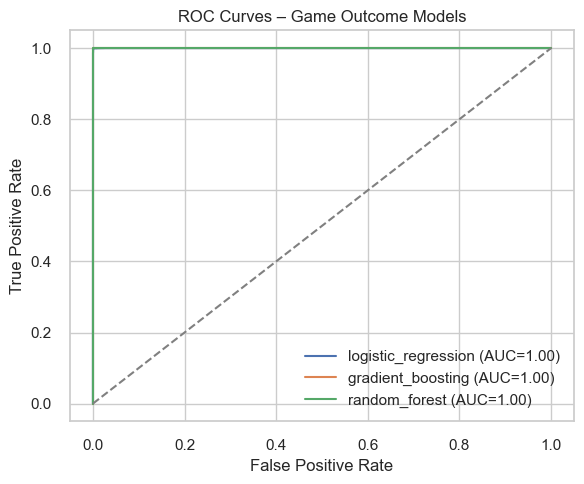

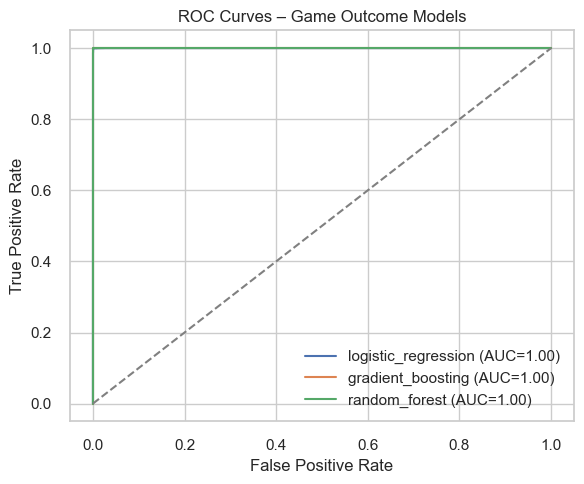

In [8]:
fig, ax = plt.subplots(figsize=(6, 5))
for name in ["logistic_regression", "gradient_boosting", "random_forest"]:
    res = evaluation_results[name]
    fpr, tpr, _ = metrics.roc_curve(y_test, res["y_score"])
    roc_auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")
ax.plot([0, 1], [0, 1], linestyle="--", color="gray")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curves – Game Outcome Models")
ax.legend()
fig.tight_layout()
roc_path = FIG_DIR / "roc_models.png"
fig.savefig(roc_path, dpi=300)
print(f"Saved ROC plot to {roc_path}")
fig

## Feature Importance (Random Forest)

In [10]:
fi_path = FIG_DIR / "feature_importance_random_forest.png"
eval_utils.plot_feature_importances(models["random_forest"], feature_cols, top_n=10, save_path=fi_path)
plt.close()
print(f"Saved feature importance figure to {fi_path}")

C:\Users\nkany\OneDrive\Desktop\Desktop\Machine Learning\Project\src\evaluation.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_values, y=sorted_features, ax=ax, palette="viridis")


Saved feature importance figure to C:\Users\nkany\OneDrive\Desktop\Desktop\Machine Learning\Project\figures\feature_importance_random_forest.png


## Discussion
- Logistic regression provides an interpretable baseline for report narratives.
- Tree-based models capture non-linear effects; feature-importance plots reveal which season metrics drive matchup wins.